In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings("ignore") 

plt.rcParams['font.size'] = 10

# Obteniendo las imágenes del dataset Standford Dogs
En este caso utilizamos un random_seed para la obtención de imágenes random del dataset

In [25]:
fpath = "/kaggle/input/stanford-dogs-dataset/images/Images"
random_seed = 42

### Obteniendo más información de las imágenes

In [26]:
img_size = 224
batch_size =32
train = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=0.2,
  subset="training",
  seed=1293,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [27]:
val = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


# Ploteando data

In [28]:
class_names = train.class_names

In [29]:
names=[]
for name in class_names :
    names.append(name.split("-")[1]) 
    
print(names[:20]) # Printing some species

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound']


### Imágen en batch para el entrenamiento

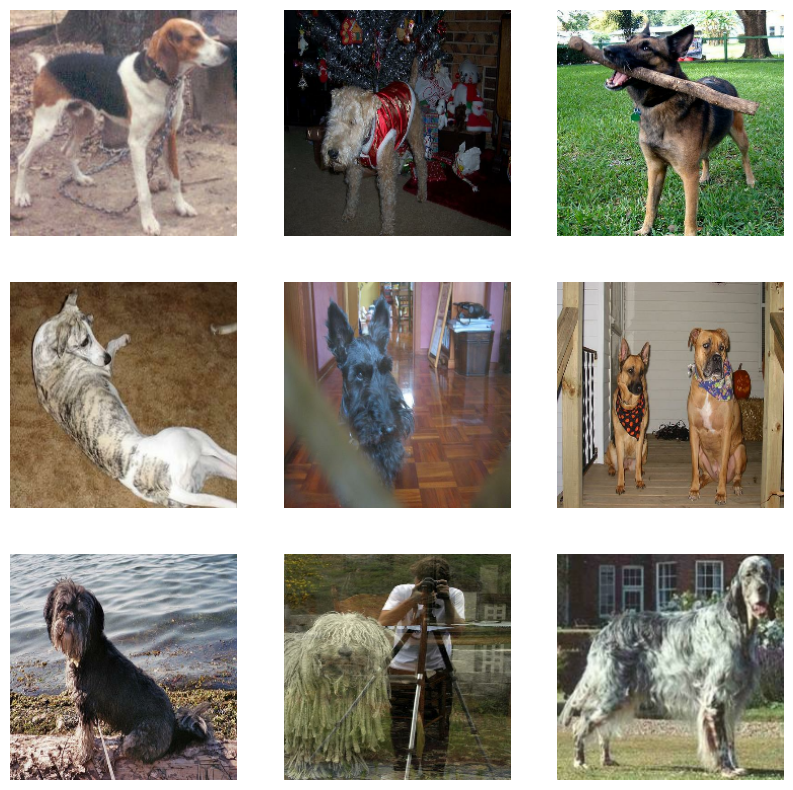

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# Construcción del model de inteligencia artificial (ResNet)
Abajo se presenta la arquitectura utilizada por ResNet
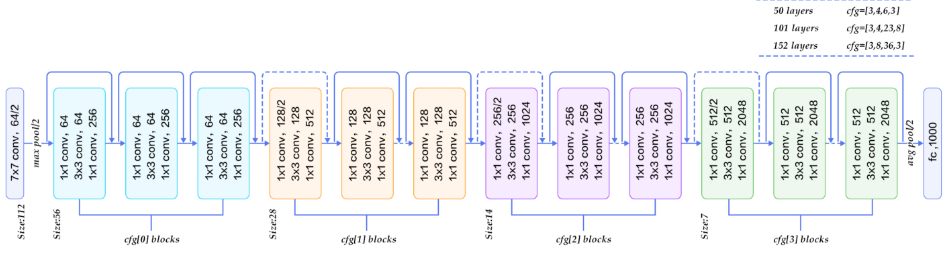

In [32]:
Model_URL ="https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2"
model = Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    hub.KerasLayer(Model_URL),
    tf.keras.layers.Dense(120, activation="softmax")])

# Compilando el modelo con el optimizador ADAM

In [33]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"] 
  )

In [36]:
model.build((img_size, img_size, 3))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 25,736,089
Trainable params: 120,240
Non-trainable params: 25,615,849
_________________________________________________________________


# Tres importantes callbacks para nuestro modelo de AI
ModelCheckpoint: Guarda el peso del modelo después de una "época" si la validación de pérdida mejora.
EarlyStopping: Detiene el proceso de entrenamiento si la validación de pérdida no mejora después de un número de épocas.
ReduceLROnPlateu: Monitorea una cantidad de datos de entrada y si no hay mejoras durante cierto número de épocas la tasa de aprendizaje disminuye

Estas 3 variables ayudarán a que el modelo no caiga en el rango de "Overfitting" y guarde el mejor modelo de acuerdo a la validación de pérdida.

In [37]:
model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

 

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5,
                                                 verbose = 1, restore_best_weights=True)

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [ ]:
history = model.fit(train, epochs=30, validation_data=val, callbacks=[checkpoint,earlystopping, reduce_lr])

Epoch 1/30
515/515 [==============================] - ETA: 0s - loss: 1.4825 - accuracy: 0.6316
Epoch 1: val_loss improved from inf to 0.71776, saving model to model.h5
515/515 [==============================] - 4241s 8s/step - loss: 1.4825 - accuracy: 0.6316 - val_loss: 0.7178 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 2/30
515/515 [==============================] - ETA: 0s - loss: 0.7575 - accuracy: 0.7808
Epoch 2: val_loss improved from 0.71776 to 0.58915, saving model to model.h5
515/515 [==============================] - 4189s 8s/step - loss: 0.7575 - accuracy: 0.7808 - val_loss: 0.5891 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 3/30
515/515 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.8300
Epoch 3: val_loss improved from 0.58915 to 0.50829, saving model to model.h5
515/515 [==============================] - 4113s 8s/step - loss: 0.5524 - accuracy: 0.8300 - val_loss: 0.5083 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 4/30
232/515 [============>..............

# Visualizando las curvas de pérdida y de certeza

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Predicción y Certeza

In [ ]:
loss, accuracy = model.evaluate(val)

In [ ]:
print(f"Accuracy is: {round(accuracy*100,2)}%")